In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import pandas as pd

from pandas import DataFrame
from IPython.display import HTML
#HTML(DataFrame(MYDATA).to_html())
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

import sys
sys.path.append('/home/maghoi/fastai/old/')

from fastai_v7.imports import *
from fastai_v7.structured import *
from fastai.tabular import * 

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


#from fastai.imports import *
#from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from plotnine import *

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!ls /scratch/maghoi/pMHC_data/features5/

In [ ]:
p0 = glob.glob("/scratch/maghoi/pMHC_data/features6/*0p*")
p1 = glob.glob("/scratch/maghoi/pMHC_data/features6/*1p*")
p2 = glob.glob("/scratch/maghoi/pMHC_data/features6/*2p*")
p3 = glob.glob("/scratch/maghoi/pMHC_data/features6/*3p*")
p4 = glob.glob("/scratch/maghoi/pMHC_data/features6/*4p*")

train = p0 + p1 + p2
valid = p3
test = p4


### Pre-proc

In [3]:
df_raw = pd.read_csv("/home/maghoi/main/data/complexes.csv", low_memory=False)
all_energy = pd.read_csv("/home/maghoi/main/data/All_Energy.csv", low_memory = False)
df_raw = df_raw.drop("Unnamed: 0", axis = 1)

#set index to first column then drop it
df_raw = df_raw.set_index(df_raw.iloc[:,0]).drop("key_0", axis = 1)
all_energy = all_energy.set_index(all_energy.iloc[:,0]).drop("Unnamed: 0", axis = 1)
all_energy.rename(columns = {"Unnamed: 0": "key_0"}, inplace = True)
all_energy.index.name = "key_0"
df_raw.index.name = "key_0"

# Removing peptide
df_raw_nopep = df_raw.copy() #already contains y_true
df_raw_energy = all_energy.copy() #need to add y_true


#Create column of zeroes (negative complexes)
zeroes = np.zeros((len(df_raw_energy),1))
zeroes = pd.DataFrame(zeroes).set_index(df_raw_energy.index)

#Merge zeroes on the right of complex_df
df = pd.merge(df_raw_energy, zeroes, on = df_raw_energy.index);
df = df.rename(columns={0 : "y_true"})

#Change zero to 1 (true complex) for all true complexes
changes = df[df.iloc[:,0].str.contains("_P")].index
df.loc[changes, "y_true"] = 1

df_raw_energy = df.copy(deep = False)

In [5]:
#Merge raw all
df_raw_energy = df_raw_energy.set_index(df_raw_energy.iloc[:,0]).drop("key_0", axis = 1)
df_raw_all = pd.merge(df_raw.drop("y_true", axis = 1), df_raw_energy, on = df_raw.index)
df_raw_all = df_raw_all.set_index(df_raw_all.key_0).drop("key_0", axis = 1)

# Remove peptide blosum scores in df_raw_nopep and raw_all_nopep
df_raw_nopep.iloc[:,181:192] = np.zeros(shape = (1464,11))

#Raw all nopep
df_raw_all_nopep = df_raw_all.copy(deep = False)
df_raw_all_nopep.iloc[:,180:191] = np.zeros(shape = (1464,11))




### Datasets

In [6]:
df_raw, y, nas = proc_df(df_raw, "y_true")
df_raw_nopep, y, nas = proc_df(df_raw_nopep, "y_true")
df_raw_energy, y, nas = proc_df(df_raw_energy, "y_true")
df_raw_all, y, nas = proc_df(df_raw_all, "y_true")
df_raw_all_nopep, y, nas = proc_df(df_raw_all_nopep, "y_true")


In [7]:
df_raw_all

0  1  2  3  4  5  6  7  8  9  ...  \
key_0                                                     ...   
1g6r_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_S1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_P1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N2_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N3_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_R1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_S1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_P1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N2_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N3_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_R1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_S1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_P1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N2_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N3_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_R1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_S1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1mwa_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_S1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
...                        .. .. .. .. .. .. .. .. .. ..  ...   
5hho_4p_P1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_N1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_N2_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_N3_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_R1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_S1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_S1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_S1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_S1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...  

### Setting up RF

In [8]:
dfs, ys, names = [df_raw, df_raw_nopep, df_raw_energy, df_raw_all, df_raw_all_nopep], [y, y, y, y, y], ["df_raw", "df_raw_nopep", "df_raw_energy", "df_raw_all", "df_raw_all_nopep"]


In [9]:
df, y = df_raw, y

### Set train, val, test by partitions

In [102]:
p0 = df_raw.index.str.contains("0p")
p1 = df_raw.index.str.contains("1p")
p2 = df_raw.index.str.contains("2p")
p3 = df_raw.index.str.contains("3p")
p4 = df_raw.index.str.contains("4p")

X_train = df_raw[p0 + p1 + p2 + p3]
y_train = y[p0 + p1 + p2 + p3]

X_valid = df_raw[p4]
y_valid = y[p4]

In [103]:
len(X_train), len(y_train), len(X_valid), len(y_valid)

(1200, 1200, 264, 264)

In [106]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = int(len(df) / 5)  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1172, 468), (1172,), (292, 468))

In [107]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

class color:
    BOLD = '\033[1m'
    END = '\033[0m'

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    
    print(color.BOLD, "MCC:", round(metrics.matthews_corrcoef(y_valid, y_hat), 5), "\tAP:",  round(metrics.average_precision_score(y_valid, y_hat), 5), color.END)
    print(color.BOLD, "TPR:", round(tp/(tp+fn), 5), "\tTNR:", round(tn/(fp+tn), 5), color.END)
    print("Confusion matrix (tn, fp, fn, tp): \n", metrics.confusion_matrix(y_valid, y_hat))
    
    #print("1. rmse: x/y train 2. rmse x/y valid 3. R^2 x/y train 4. R^2 x/y valid, 5. m.oob_score_")
    print(res[0:2], res[4:], "RMSE x/y t/v, oob_score")
    print(res[2:4], "R^2 x/y train/valid")
    
def quick_print(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    
    mcc = round(metrics.matthews_corrcoef(y_valid, y_hat), 5)
    ap = round(metrics.average_precision_score(y_valid, y_hat), 5)
    tpr = round(tp/(tp+fn), 5)
    tnr = round(tn/(fp+tn), 5)
    
    print(color.BOLD, "MCC:", mcc, "\tAP:", ap, color.END)
    print(color.BOLD, "TPR:", tpr, "\tTNR:", tnr, color.END)
    
    values = [mcc, ap, tpr, tnr]
    return values

def no_print(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    y_hat = np.where(m.predict(X_valid) <= 0.5, 0, 1)
    tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_hat).ravel()
    
    mcc = round(metrics.matthews_corrcoef(y_valid, y_hat), 5)
    ap = round(metrics.average_precision_score(y_valid, y_hat), 5)
    tpr = round(tp/(tp+fn), 5)
    tnr = round(tn/(fp+tn), 5)
    
    values = [mcc, ap, tpr, tnr]
    return values
    
    

### Partition RF

In [110]:
set_rf_samples(int((10/10)*len(X_train))) #Random forest samples from all of rows (performs better)
m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

 MCC: 0.83204 	AP: 0.77369 
 TPR: 0.72917 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[244   0]
 [ 13  35]]
[0.04682452882635757, 0.21547077321434813] [0.8868364032319563] RMSE x/y t/v, oob_score
[0.984256685683153, 0.6620041410519124] R^2 x/y train/valid


In [111]:
y_pred = m.predict(X_valid)
y_true = y_valid
stats(y_pred, y_true)

Correct: 0.955
AUC 0.977
MCC 0.832
AVP 0.94

Tn, fp, fn, tp
[[244   0]
 [ 13  35]]
TPR: 0.729
TNR: 1.0


In [65]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import average_precision_score
from sklearn import random_projection
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

In [64]:
def stats(y_hat, y_true):
    #Pairwise comparison
    yhat = np.array(y_hat)
    y_true = np.array(y_true)
    yhat_binary = np.where(y_hat > 0.5, 1, 0)

    correct = yhat_binary == y_true
    auc = roc_auc_score(y_true, yhat)
    mcc = matthews_corrcoef(y_true, yhat_binary)
    avp = average_precision_score(y_true, yhat)

    print("Correct:", round(sum(correct) / len(y_true), 3))
    print("AUC", round(auc, 3))
    print("MCC", round(mcc, 3))
    print("AVP", round(avp, 3))

    print("\nTn, fp, fn, tp")
    print(metrics.confusion_matrix(y_true, yhat_binary))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat_binary).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    print("TPR:", round(tpr, 3))
    print("TNR:", round(tnr, 3))


### Quick RF

In [313]:
for df, y, name in zip(dfs, ys, names):
    df_trn, y_trn = df, y
    
    n_valid = int(len(df) / 6) # validation = 1/6th of set
    n_trn = len(df)-n_valid
    X_train, X_valid = split_vals(df, n_trn)
    y_train, y_valid = split_vals(y, n_trn)
    print("\n ### Set:", name)
    print("Train x, train y, valid x shape:\n", X_train.shape, y_train.shape, X_valid.shape)
    
    set_rf_samples(int((10/10)*len(df_trn))) #Random forest samples from all of rows (performs better)
    
    
    m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)


 ### Set: df_raw
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.86154 	AP: 0.81189 
 TPR: 0.775 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [  9  31]]
[0.036721580835923355, 0.21039214946707743] [0.8933927175274798] RMSE x/y t/v, oob_score
[0.9903163624920658, 0.6770401348039216] R^2 x/y train/valid

 ### Set: df_raw_nopep
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.41579 	AP: 0.33115 
 TPR: 0.2 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 32   8]]
[0.31135227282525196, 0.3470906785315443] [-0.004143035135086848] RMSE x/y t/v, oob_score
[0.30385474596760076, 0.12102728337549394] R^2 x/y train/valid

 ### Set: df_raw_energy
Train x, train y, valid x shape:
 (1220, 266) (1220,) (244, 266)


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16393 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 40   0]]
[0.09054329037368804, 0.3425522476203109] [0.3696655930544245] RMSE x/y t/v, oob_score
[0.9411280621172353, 0.1438632557189541] R^2 x/y train/valid

 ### Set: df_raw_all
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.29155 	AP: 0.24754 
 TPR: 0.1 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 36   4]]
[0.07869936860806338, 0.30182024062390717] [0.5040298395467406] RMSE x/y t/v, oob_score
[0.955522713651296, 0.33536039624183] R^2 x/y train/valid

 ### Set: df_raw_all_nopep
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.29155 	AP: 0.24754 
 TPR: 0.1 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 36   4]]
[0.08492603660826914, 0.3189141377100264] [0.4189222816070707] RMSE x/y t/v, oob_score
[0.9482062329524986, 0.25794338916121995] R^2 x/y train/valid


### Cross-validation

In [314]:
def cross_vals(df, n_trn, i): 
    start = n_valid*i
    end = n_valid*(i+1)
    train = np.append(df[0:start], df[end:], axis = 0).copy()
    valid = df[start:end].copy()
    
    #print("Valid:", start, end)
    return(train, valid)

In [315]:
partitions = [0, 1, 2, 3, 4, 5]
for df, y, name in zip(dfs, ys, names):
    print("\n-------------\n")
    for i in partitions:
        print("\nSet:", name, "run", i+1, "of", partitions[-1]+1)
        
        df_trn, y_trn = df, y
        n_valid = int(len(df) / 6) # validation = 1/6th of set
        n_trn = len(df)-n_valid

        X_train, X_valid = cross_vals(df, n_trn, i)
        y_train, y_valid = cross_vals(y, n_trn, i)
        print("Train x, train y, valid x shape:\n", X_train.shape, y_train.shape, X_valid.shape)

        set_rf_samples(int((10/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        print_score(m)


-------------


Set: df_raw run 1 of 6
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.75738 	AP: 0.67447 
 TPR: 0.7561 	TNR: 0.97044 
Confusion matrix (tn, fp, fn, tp): 
 [[197   6]
 [ 10  31]]
[0.03703260636825646, 0.23862319489919245] [0.8973093221360211] RMSE x/y t/v, oob_score
[0.9901128476006413, 0.5926900022694808] R^2 x/y train/valid

Set: df_raw run 2 of 6
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.94074 	AP: 0.91883 
 TPR: 0.90244 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [  4  37]]
[0.039824009471912086, 0.14903396423448673] [0.8831155590619041] RMSE x/y t/v, oob_score
[0.9885661461772742, 0.841119621664197] R^2 x/y train/valid

Set: df_raw run 3 of 6
Train x, train y, valid x shape:
 (1220, 468) (1220,) (244, 468)
 MCC: 0.86154 	AP: 0.81189 
 TPR: 0.775 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [  9  31]]
[0.035553616608106284, 0.19437531297745084] [0.9058743180483201] RMSE x/y t/v, 

/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 41   0]]
[0.08765014440494465, 0.3494482379956313] [0.4017621587959239] RMSE x/y t/v, oob_score
[0.9446129872625143, 0.12649485361848667] R^2 x/y train/valid

Set: df_raw_energy run 2 of 6
Train x, train y, valid x shape:
 (1220, 266) (1220,) (244, 266)
 MCC: 0.14274 	AP: 0.18832 
 TPR: 0.02439 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 40   1]]
[0.0904118032738005, 0.3349627184757586] [0.3735646846546029] RMSE x/y t/v, oob_score
[0.9410677621108909, 0.19741192411924102] R^2 x/y train/valid

Set: df_raw_energy run 3 of 6
Train x, train y, valid x shape:
 (1220, 266) (1220,) (244, 266)
 MCC: 0.2053 	AP: 0.20574 
 TPR: 0.05 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 38   2]]
[0.09166511424418183, 0.3260186153009804] [0.3394028087605737] RMSE x/y t/v, oob_score
[0.9396601878120016, 0.22451341230936817] R^2 x/y train/valid

Set: df_raw_energy run 4 of 6
Trai

/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 41   0]]
[0.08666824294489203, 0.3504875604848834] [0.403638322872128] RMSE x/y t/v, oob_score
[0.9458469833304539, 0.12129120108935076] R^2 x/y train/valid

Set: df_raw_energy run 5 of 6
Train x, train y, valid x shape:
 (1220, 266) (1220,) (244, 266)


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 41   0]]
[0.08962613350425018, 0.3535558055672021] [0.3743181803324619] RMSE x/y t/v, oob_score
[0.9420875426991285, 0.10583904041010828] R^2 x/y train/valid

Set: df_raw_energy run 6 of 6
Train x, train y, valid x shape:
 (1220, 266) (1220,) (244, 266)


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16393 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 40   0]]
[0.08867157377850589, 0.33947467586781127] [0.3888413736316453] RMSE x/y t/v, oob_score
[0.943536912933371, 0.15917762799564283] R^2 x/y train/valid

-------------


Set: df_raw_all run 1 of 6
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 41   0]]
[0.07578182361574728, 0.32472359340357854] [0.5389140011798804] RMSE x/y t/v, oob_score
[0.958596908117557, 0.2457289372154804] R^2 x/y train/valid

Set: df_raw_all run 2 of 6
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.52786 	AP: 0.43183 
 TPR: 0.31707 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 28  13]]
[0.08163187895180525, 0.27499016789842046] [0.4668508539920567] RMSE x/y t/v, oob_score
[0.9519578697447176, 0.4590786909100617] R^2 x/y train/valid

Set: df_raw_all run 3 of 6
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.41579 	AP: 0.33115 
 TPR: 0.2 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 32   8]]
[0.08520640855175035, 0.29523866576586105] [0.4539462607698579] RMSE x/y t/v, oob_score
[0.9478636880714667, 0.3640309776688453] R^2 x/y train/valid

Set: df_raw_all run 4 of 6
Train x, trai

/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 41   0]]
[0.08326055565214872, 0.33454867240455505] [0.45572102443302753] RMSE x/y t/v, oob_score
[0.9500217229377538, 0.1993948496135205] R^2 x/y train/valid

Set: df_raw_all_nopep run 2 of 6
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.40968 	AP: 0.33037 
 TPR: 0.19512 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[203   0]
 [ 33   8]]
[0.08899260371223384, 0.28342372392933957] [0.38800496587937594] RMSE x/y t/v, oob_score
[0.9429033671697183, 0.425391351943076] R^2 x/y train/valid

Set: df_raw_all_nopep run 3 of 6
Train x, train y, valid x shape:
 (1220, 734) (1220,) (244, 734)
 MCC: 0.25196 	AP: 0.22664 
 TPR: 0.075 	TNR: 1.0 
Confusion matrix (tn, fp, fn, tp): 
 [[204   0]
 [ 37   3]]
[0.08891069433135992, 0.3176009011677809] [0.3955859274340764] RMSE x/y t/v, oob_score
[0.943231974411593, 0.26404214324618736] R^2 x/y train/valid

Set: df_raw_all_nopep run

### Quick-print

In [316]:
output = ""
partitions = [0, 1, 2, 3, 4, 5]
for df, y, name in zip(dfs, ys, names):
    print("-------------")
    for i in partitions:
        print("\nSet:", name, "run", i+1, "of", partitions[-1]+1)
        df_trn, y_trn = df, y
        n_valid = int(len(df) / 6) # validation = 1/6th of set
        n_trn = len(df)-n_valid
        X_train, X_valid = cross_vals(df, n_trn, i)
        y_train, y_valid = cross_vals(y, n_trn, i)
        set_rf_samples(int((10/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        
        quick_print(m)
        
        
        
        

-------------

Set: df_raw run 1 of 6
 MCC: 0.79955 	AP: 0.73106 
 TPR: 0.73171 	TNR: 0.99015 

Set: df_raw run 2 of 6
 MCC: 0.94074 	AP: 0.91883 
 TPR: 0.90244 	TNR: 1.0 

Set: df_raw run 3 of 6
 MCC: 0.84459 	AP: 0.78767 
 TPR: 0.775 	TNR: 0.9951 

Set: df_raw run 4 of 6
 MCC: 0.83312 	AP: 0.77679 
 TPR: 0.73171 	TNR: 1.0 

Set: df_raw run 5 of 6
 MCC: 0.83312 	AP: 0.77679 
 TPR: 0.73171 	TNR: 1.0 

Set: df_raw run 6 of 6
 MCC: 0.84555 	AP: 0.79098 
 TPR: 0.75 	TNR: 1.0 
-------------

Set: df_raw_nopep run 1 of 6
 MCC: 0.18354 	AP: 0.20852 
 TPR: 0.12195 	TNR: 0.97537 

Set: df_raw_nopep run 2 of 6
 MCC: 0.52282 	AP: 0.42937 
 TPR: 0.36585 	TNR: 0.99015 

Set: df_raw_nopep run 3 of 6
 MCC: 0.21383 	AP: 0.22004 
 TPR: 0.2 	TNR: 0.95098 

Set: df_raw_nopep run 4 of 6
 MCC: 0.50606 	AP: 0.41154 
 TPR: 0.29268 	TNR: 1.0 

Set: df_raw_nopep run 5 of 6
 MCC: 0.20228 	AP: 0.20862 
 TPR: 0.04878 	TNR: 1.0 

Set: df_raw_nopep run 6 of 6
 MCC: 0.41579 	AP: 0.33115 
 TPR: 0.2 	TNR: 1.0 
------

/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_energy run 2 of 6
 MCC: 0.14274 	AP: 0.18832 
 TPR: 0.02439 	TNR: 1.0 

Set: df_raw_energy run 3 of 6
 MCC: 0.2053 	AP: 0.20574 
 TPR: 0.05 	TNR: 1.0 

Set: df_raw_energy run 4 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_energy run 5 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_energy run 6 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16393 
 TPR: 0.0 	TNR: 1.0 
-------------

Set: df_raw_all run 1 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_all run 2 of 6
 MCC: 0.50606 	AP: 0.41154 
 TPR: 0.29268 	TNR: 1.0 

Set: df_raw_all run 3 of 6
 MCC: 0.32664 	AP: 0.26844 
 TPR: 0.125 	TNR: 1.0 

Set: df_raw_all run 4 of 6
 MCC: 0.24826 	AP: 0.22891 
 TPR: 0.07317 	TNR: 1.0 

Set: df_raw_all run 5 of 6
 MCC: 0.20228 	AP: 0.20862 
 TPR: 0.04878 	TNR: 1.0 

Set: df_raw_all run 6 of 6
 MCC: 0.29155 	AP: 0.24754 
 TPR: 0.1 	TNR: 1.0 
-------------

Set: df_raw_all_nopep run 1 of 6


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 MCC: 0.0 	AP: 0.16803 
 TPR: 0.0 	TNR: 1.0 

Set: df_raw_all_nopep run 2 of 6
 MCC: 0.45999 	AP: 0.37095 
 TPR: 0.2439 	TNR: 1.0 

Set: df_raw_all_nopep run 3 of 6
 MCC: 0.25196 	AP: 0.22664 
 TPR: 0.075 	TNR: 1.0 

Set: df_raw_all_nopep run 4 of 6
 MCC: 0.20228 	AP: 0.20862 
 TPR: 0.04878 	TNR: 1.0 

Set: df_raw_all_nopep run 5 of 6
 MCC: 0.14274 	AP: 0.18832 
 TPR: 0.02439 	TNR: 1.0 

Set: df_raw_all_nopep run 6 of 6
 MCC: 0.32664 	AP: 0.26844 
 TPR: 0.125 	TNR: 1.0 


### Noprint

In [324]:
names[2]

'df_raw_energy'

In [325]:
dfs[2]

M_total energy  M_Backbone Hbond  \
key_0                                                          
1g6r_1p_P1_1t_99s_pMHC-TCR         43.8599          -121.401   
1g6r_1p_N1_1t_99s_pMHC-TCR         33.0047          -130.811   
1g6r_1p_N2_1t_99s_pMHC-TCR         32.7762          -132.186   
1g6r_1p_N3_1t_99s_pMHC-TCR         25.6722          -133.606   
1g6r_1p_R1_1t_99s_pMHC-TCR         26.2620          -130.927   
1g6r_1p_S1_1t_99s_pMHC-TCR         42.5881          -127.009   
1g6r_1p_P1_1t_95s_pMHC-TCR         47.9869          -122.997   
1g6r_1p_N1_1t_95s_pMHC-TCR         35.6672          -131.487   
1g6r_1p_N2_1t_95s_pMHC-TCR         43.3983          -127.784   
1g6r_1p_N3_1t_95s_pMHC-TCR         34.7800          -130.817   
1g6r_1p_R1_1t_95s_pMHC-TCR         20.7450          -135.223   
1g6r_1p_S1_1t_95s_pMHC-TCR         42.5881          -127.009   
1g6r_1p_P1_1t_90s_pMHC-TCR         38.0777          -123.242   
1g6r_1p_N1_1t_90s_pMHC-TCR         32.0869          -134.871   
1g6r_1p_N2_1t_90s_pMHC-TCR         36.0466          -131.451   
1g6r_1p_N3_1t_90s_pMHC-TCR         23.7637          -135.817   
1g6r_1p_R1_1t_90s_pMHC-TCR         21.3380          -130.800   
1g6r_1p_S1_1t_90s_pMHC-TCR         42.5881          -127.009   
1g6r_1p_P1_1t_80s_pMHC-TCR         61.4802          -116.470   
1g6r_1p_N1_1t_80s_pMHC-TCR         32.6174          -136.964   
1g6r_1p_N2_1t_80s_pMHC-TCR         24.0108          -138.908   
1g6r_1p_N3_1t_80s_pMHC-TCR         29.6723          -138.857   
1g6r_1p_R1_1t_80s_pMHC-TCR         19.5764          -144.339   
1g6r_1p_S1_1t_80s_pMHC-TCR         46.4203          -122.153   
1mwa_1p_P1_1t_99s_pMHC-TCR         59.4287          -126.307   
1mwa_1p_N1_1t_99s_pMHC-TCR         36.6789          -135.752   
1mwa_1p_N2_1t_99s_pMHC-TCR         28.8329          -133.609   
1mwa_1p_N3_1t_99s_pMHC-TCR         39.6564          -132.069   
1mwa_1p_R1_1t_99s_pMHC-TCR         41.5657          -132.137   
1mwa_1p_S1_1t_99s_pMHC-TCR         63.7752          -128.563   
...                                    ...               ...   
5hho_4p_P1_1t_80s_pMHC-TCR         43.1022          -138.241   
5hho_4p_N1_1t_80s_pMHC-TCR         26.9029          -145.370   
5hho_4p_N2_1t_80s_pMHC-TCR         20.4134          -142.530   
5hho_4p_N3_1t_80s_pMHC-TCR         32.6884          -137.850   
5hho_4p_R1_1t_80s_pMHC-TCR         23.0201          -140.478   
5hho_4p_S1_1t_80s_pMHC-TCR         56.5885          -138.563   
5men_0p_P1_1t_99s_pMHC-TCR         34.3450          -137.366   
5men_0p_N1_1t_99s_pMHC-TCR         43.5015          -133.924   
5men_0p_N2_1t_99s_pMHC-TCR         40.9215          -139.249   
5men_0p_N3_1t_99s_pMHC-TCR         36.6938          -136.107   
5men_0p_R1_1t_99s_pMHC-TCR         37.4091          -140.261   
5men_0p_S1_1t_99s_pMHC-TCR         57.1499          -135.640   
5men_0p_P1_1t_95s_pMHC-TCR         31.3410          -133.143   
5men_0p_N1_1t_95s_pMHC-TCR         42.8556          -139.943   
5men_0p_N2_1t_95s_pMHC-TCR         35.5864          -138.738   
5men_0p_N3_1t_95s_pMHC-TCR         37.0827          -136.312   
5men_0p_R1_1t_95s_pMHC-TCR         33.9896          -138.572   
5men_0p_S1_1t_95s_pMHC-TCR         28.7505          -135.379   
5men_0p_P1_1t_90s_pMHC-TCR         41.5823          -133.021   
5men_0p_N1_1t_90s_pMHC-TCR         32.3616          -142.582   
5men_0p_N2_1t_90s_pMHC-TCR         22.2436          -141.849   
5men_0p_N3_1t_90s_pMHC-TCR         37.7567          -135.491   
5men_0p_R1_1t_90s_pMHC-TCR         31.3661          -140.749   
5men_0p_S1_1t_90s_pMHC-TCR         27.1967          -136.590   
5men_0p_P1_1t_80s_pMHC-TCR         40.4614          -137.219   
5men_0p_N1_1t_80s_pMHC-TCR         36.9587          -144.033   
5men_0p_N2_1t_80s_pMHC-TCR         31.5761          -141.021   
5men_0p_N3_1t_80s_pMHC-TCR         40.1811          -136.156   
5men_0p_R1_1t_80s_pMHC-TCR         36.1609          -133.004   
5men_0p_S1_1t_80s_pMHC-TCR         42.2487          -137.275

In [330]:

partitions = [0, 1, 2, 3, 4, 5]
for df, y, name in zip(dfs, ys, names):
    values = []
    print("-------------")
    for i in partitions:
        df_trn, y_trn = df, y
        n_valid = int(len(df) / 6) # validation = 1/6th of set
        n_trn = len(df)-n_valid
        X_train, X_valid = cross_vals(df, n_trn, i)
        y_train, y_valid = cross_vals(y, n_trn, i)
        set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

        m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        values.append(no_print(m))
        print("Set:", name, "run", i+1, "of", partitions[-1]+1, values[-1])

    output = pd.DataFrame(values)
    output.columns = ["MCC", "AP", "TPR", "TNR"]
    print("\n", name, "\n",output.describe())

        
        
        

-------------
Set: df_raw run 1 of 6 [0.83203, 0.77146, 0.78049, 0.99015]
Set: df_raw run 2 of 6 [0.88273, 0.83079, 0.90244, 0.9803]
Set: df_raw run 3 of 6 [0.93941, 0.91295, 0.925, 0.9951]
Set: df_raw run 4 of 6 [0.69522, 0.59906, 0.7561, 0.94581]
Set: df_raw run 5 of 6 [0.67752, 0.58048, 0.73171, 0.94581]
Set: df_raw run 6 of 6 [0.72858, 0.64118, 0.675, 0.98039]

 df_raw 
             MCC        AP       TPR       TNR
count  6.000000  6.000000  6.000000  6.000000
mean   0.792582  0.722653  0.795123  0.972927
std    0.107755  0.135952  0.098562  0.021767
min    0.677520  0.580480  0.675000  0.945810
25%    0.703560  0.609590  0.737807  0.954433
50%    0.780305  0.706320  0.768295  0.980345
75%    0.870055  0.815958  0.871953  0.987710
max    0.939410  0.912950  0.925000  0.995100
-------------
Set: df_raw_nopep run 1 of 6 [0.21933, 0.22327, 0.14634, 0.97537]
Set: df_raw_nopep run 2 of 6 [0.44833, 0.36788, 0.36585, 0.97044]
Set: df_raw_nopep run 3 of 6 [0.27576, 0.25449, 0.375, 0.89216

### Multipe runs, optimized hyperparams

In [334]:
values = []
partitions = [0, 1, 2, 3, 4, 5]
for df, y, name in zip(dfs, ys, names):
    for runs in range(0, 5):
        #print("-------------")
        for i in partitions:
            df_trn, y_trn = df, y
            n_valid = int(len(df) / 6) # validation = 1/6th of set
            n_trn = len(df)-n_valid
            X_train, X_valid = cross_vals(df, n_trn, i)
            y_train, y_valid = cross_vals(y, n_trn, i)
            set_rf_samples(int((8/10)*len(df_trn))) #Random forest samples from all of rows (performs better)

            m = RandomForestRegressor(n_estimators=150, max_features=0.5, n_jobs=-1, oob_score=True)
            m.fit(X_train, y_train)
            values.append(no_print(m))
            #print("Set:", name, "run", i+1, "of", partitions[-1]+1, values[-1])

    output = pd.DataFrame(values)
    output.columns = ["MCC", "AP", "TPR", "TNR"]
    print("\n", name, "\n",output.describe())

        
        
        


 df_raw 
              MCC         AP        TPR        TNR
count  30.000000  30.000000  30.000000  30.000000
mean    0.801262   0.734905   0.790123   0.976525
std     0.102781   0.131292   0.099030   0.023206
min     0.677520   0.580480   0.625000   0.945810
25%     0.695220   0.599060   0.731710   0.945810
50%     0.783925   0.709640   0.768295   0.982840
75%     0.882730   0.830790   0.902440   1.000000
max     0.954770   0.937300   0.925000   1.000000

 df_raw_nopep 
              MCC         AP        TPR        TNR
count  60.000000  60.000000  60.000000  60.000000
mean    0.557598   0.507663   0.522022   0.968697
std     0.266495   0.251822   0.291058   0.030875
min     0.202280   0.208620   0.048780   0.892160
25%     0.296637   0.263482   0.292680   0.945810
50%     0.602690   0.506155   0.507620   0.980300
75%     0.781917   0.708510   0.762197   1.000000
max     0.954770   0.937300   0.925000   1.000000

 df_raw_energy 
              MCC         AP        TPR        TNR
coun

KeyboardInterrupt: 

In [335]:
dfs[0]

0  1  2  3  4  5  6  7  8  9  ...  458  459  460  \
key_0                                                     ...                  
1g6r_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1g6r_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1g6r_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1g6r_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1g6r_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1g6r_1p_S1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1g6r_1p_P1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N2_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N3_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_R1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_S1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_P1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N2_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N3_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_R1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_S1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_P1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N2_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_N3_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_R1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1g6r_1p_S1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...    6    6    4   
1mwa_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1mwa_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1mwa_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1mwa_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1mwa_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
1mwa_1p_S1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...    6    6   -1   
...                        .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...   
5hho_4p_P1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    7   
5hho_4p_N1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    7   
5hho_4p_N2_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    7   
5hho_4p_N3_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    7   
5hho_4p_R1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    7   
5hho_4p_S1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    7   
5men_0p_P1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_N1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_N2_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_N3_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_R1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    0   
5men_0p_S1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    4   
5men_0p_P1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_N1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_N2_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_N3_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    2   
5men_0p_R1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...    6    6    0   
5men_0p_S1_1t_90s_pMHC-TCR  

In [337]:
import random

In [375]:
#Random number 0-10
l = []
for i in range(0, 100000):
    l.append(int(random.random()*11))
pd.DataFrame(l).describe()

0
count  100000.000000
mean        5.004760
std         3.161072
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        10.000000

In [408]:
#Random number 0-10
l = []
for i in range(0, 100000):
    l.append(random.choice(range(0,11)))
pd.DataFrame(l).describe()

0
count  100000.000000
mean        5.012220
std         3.159771
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        10.000000

In [ ]:
random.choice(range(0,10))

In [384]:
peptide = df_raw.iloc[:, 181:191]
peptide_pos = peptide[peptide.index.str.contains("_P")]
peptide_high = peptide[peptide.index.str.contains("_N")]
peptide_low = peptide[peptide.index.str.contains("_R")]
peptide_switch = peptide[peptide.index.str.contains("_S")]

In [ ]:
#high + low combine

In [385]:
peptide_pos

181  182  183  184  185  186  187  188  189  190
key_0                                                                       
1g6r_1p_P1_1t_80s_pMHC-TCR    1   -1    3   -1   -1   -3    0    2   -4   -4
1g6r_1p_P1_1t_90s_pMHC-TCR    0   -3    7    2    3    7    0    1   -4   -4
1g6r_1p_P1_1t_95s_pMHC-TCR    0   -3    7    2    3    7    0    1   -4   -4
1g6r_1p_P1_1t_99s_pMHC-TCR    0   -3    7    2    3    7    0    1   -4   -4
1mwa_1p_P1_1t_80s_pMHC-TCR   -1   -1    3   -1    0   -3    4    3   -4   -4
1mwa_1p_P1_1t_90s_pMHC-TCR    0   -3    7    2    3    7    0    1   -4   -4
1mwa_1p_P1_1t_95s_pMHC-TCR    0   -3    7    2    3    7    0    1   -4   -4
1mwa_1p_P1_1t_99s_pMHC-TCR    0   -3    7    2    3    7    0    1   -4   -4
2bnq_2p_P1_1t_80s_pMHC-TCR    1    4    1   -2   -1    3    0   -1    4   -4
2bnq_2p_P1_1t_90s_pMHC-TCR    1    4    1   -2   -1    3    0   -1    4   -4
2bnq_2p_P1_1t_95s_pMHC-TCR    4    4    4    5   11    4    5    5   -1   -4
2bnq_2p_P1_1t_99s_pMHC-TCR    4    4    4    5   11    4    5    5   -1   -4
2bnr_2p_P1_1t_80s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2bnr_2p_P1_1t_90s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2bnr_2p_P1_1t_95s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2bnr_2p_P1_1t_99s_pMHC-TCR    4    4    4    5   11    4    5    5    9   -4
2e7l_3p_P1_1t_80s_pMHC-TCR    0   -3    1    7   -3    7    0    6    4   -4
2e7l_3p_P1_1t_90s_pMHC-TCR    5    4    4   -1   -1    7    0    6    4   -4
2e7l_3p_P1_1t_95s_pMHC-TCR    5    4    4   -1   -1    7    0    6    4   -4
2e7l_3p_P1_1t_99s_pMHC-TCR    5    4    4    7    6    7    6    6    4   -4
2f53_2p_P1_1t_80s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2f53_2p_P1_1t_90s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2f53_2p_P1_1t_95s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2f53_2p_P1_1t_99s_pMHC-TCR    4    4    4    5   11    4    5    5    9   -4
2f54_2p_P1_1t_80s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2f54_2p_P1_1t_90s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2f54_2p_P1_1t_95s_pMHC-TCR   -2    4   -1   -1    1    2   -2   -2   -1   -4
2f54_2p_P1_1t_99s_pMHC-TCR    4    4    4    5   11    4    5    5    9   -4
2nx5_2p_P1_1t_80s_pMHC-TCR    0    7    1   -2    5    0    0   -1   -2   -1
2nx5_2p_P1_1t_90s_pMHC-TCR    0    7    1   -2    5    0    0   -1   -2   -1
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
5c09_1p_P1_1t_95s_pMHC-TCR   -2   -2   -3    6    7    6    6    7    5    4
5c09_1p_P1_1t_99s_pMHC-TCR   -2   -2   -3    6    7    6    6    7    5    4
5d2n_0p_P1_1t_80s_pMHC-TCR    6    4    4    7    5    4    4    5    4   -4
5d2n_0p_P1_1t_90s_pMHC-TCR    6    4    4    7    5    4    4    5    4   -4
5d2n_0p_P1_1t_95s_pMHC-TCR    6    4    4    7    5    4    4    5    4   -4
5d2n_0p_P1_1t_99s_pMHC-TCR    6    4    4    7    5    4    4    5    4   -4
5e9d_0p_P1_1t_80s_pMHC-TCR   -2    1   -3    6   -3   -1   -3    4   -2    4
5e9d_0p_P1_1t_90s_pMHC-TCR    5    4    4    6    4    6    4    4    5    4
5e9d_0p_P1_1t_95s_pMHC-TCR    5    4    4    6    4    6    4    4    5    4
5e9d_0p_P1_1t_99s_pMHC-TCR    5    4    4    6    4    6    4    4    5    4
5eu6_0p_P1_1t_80s_pMHC-TCR   -2    4   -2    7   -3   -2    0    5    4   -4
5eu6_0p_P1_1t_90s_pMHC-TCR   -2    4   -2    7   -3   -2    0    5    4   -4
5eu6_0p_P1_1t_95s_pMHC-TCR   -2    4   -2    7   -3   -2    0    5    4   -4
5eu6_0p_P1_1t_99s_pMHC-TCR   -2    4   -2    7   -3   -2    0    5    4   -4
5euo_4p_P1_1t_80s_pMHC-TCR   -4    2   -1   -2    6    1   -1   -2    4   -4
5euo_4p_P1_1t_90s_pMHC-TCR   -4    2   -1   -2    6    1   -1   -2    4   -4
5euo_4p_P1_1t_95s_pMHC-TCR   -4    2   -1   -2    6    1   -1   -2    4   -4
5euo_4p_P1_1t_99s_pMHC-TCR    6    4    4    6    6    4    6    5    4   -4
5hhm_4p_P1_1t_80s_pMHC-TCR    6    2   -1   -2    4    4   -2   -1    4   -4
5hhm_4p_P1_1t_90s_pMHC-T

In [590]:
len(neg.index)

732

In [675]:
neg = neg.copy()
def sim_anneal(pos, neg):
    print("Before:", len(neg.index))
    for i in range(0, 1500):
        pos_np = pd.DataFrame(pos.to_numpy().flatten())
        neg_np = pd.DataFrame(neg.to_numpy().flatten())
        score_0 = scipy.stats.mannwhitneyu(pos_np, neg_np).pvalue
        # print("Score_0", score_0)

        choice = random.choice(neg.index)
        neg_np = pd.DataFrame(neg.drop(choice).to_numpy().flatten())
        score_1 = scipy.stats.mannwhitneyu(pos_np, neg_np).pvalue
        #print("Score_1", score_1)

        #print("Choice:", choice)
        delta_score = np.log(score_0) - np.log(score_1)

        if delta_score < 0:
            if ((np.exp(-delta_score/1)-1) > random.random()):
                neg = neg.drop(choice)
                print("Increased", delta_score)
        else:
            print("Decreased", delta_score)
            
    print("After:", len(neg.index))
    print(score_1)
    return(neg)

In [676]:
pos = peptide_pos.copy()
neg = peptide_high.copy()

In [677]:
pos_np = pd.DataFrame(pos.to_numpy().flatten())
neg_np = pd.DataFrame(neg.to_numpy().flatten())
score_0 = scipy.stats.mannwhitneyu(pos_np, neg_np).pvalue
print(score_0)
neg = sim_anneal(pos, neg)

4.4217061397069526e-226
Before: 732
Decreased 0.4459192957945106
Increased -0.5179443184609909
Decreased 0.007810249540170844
Decreased 0.33459968193619716
Increased -0.39808448729706924
Increased -0.7588341319941492
Decreased 0.014800383115584737
Decreased 0.2166675043296209
Increased -0.23307634506409158
Decreased 0.4450583676214137
Decreased 0.016612363465696944
Decreased 0.7288175412809323
Increased -0.1614798582641015
Increased -0.4787231728109873
Decreased 0.7293990664600187
Decreased 0.46330646813623844
Increased -0.9071101941221968
Increased -0.6460418458725599
Increased -0.7857650646487855
Decreased 0.010112820330277827
Increased -0.715198025659447
Decreased 0.44239444872130207
Decreased 0.3092816491174517
Increased -0.8461862935098452
Increased -0.46768344380336657
Increased -0.2743066891742387
Decreased 0.007441792119493584
Increased -0.27184126752121074
Increased -0.7670686641859561
Increased -0.4762819095188888
Decreased 0.5064620236332757
Increased -0.31344660988833084
De

In [678]:
pos.shape

(244, 10)

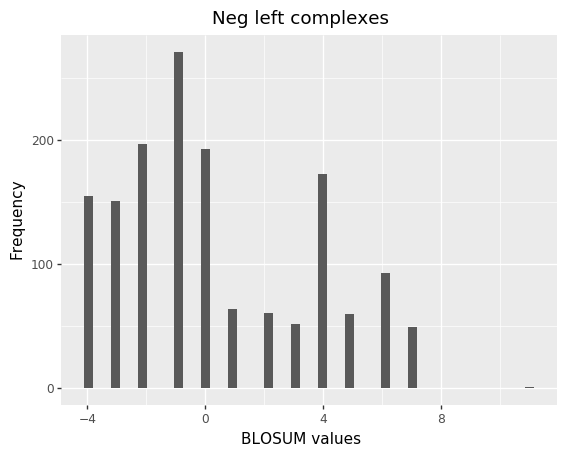

<ggplot: (-9223363246794971560)>

In [679]:
df = pd.DataFrame(neg.to_numpy().flatten())
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM values")
    + ylab("Frequency")
    + ggtitle("Neg left complexes")
)

### Histogram shapes

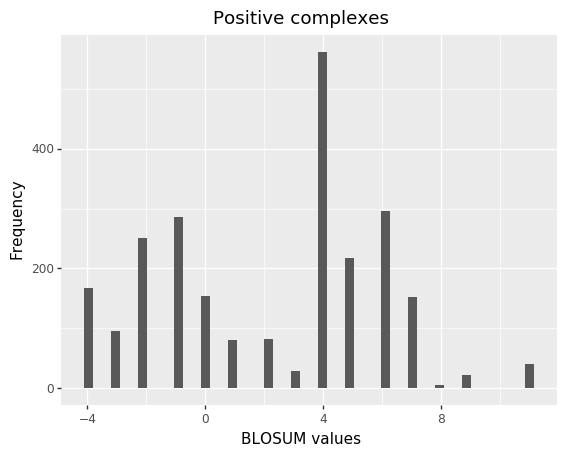

<ggplot: (8790059734427)>

In [680]:
df = pd.DataFrame(peptide_pos.to_numpy().flatten())
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM values")
    + ylab("Frequency")
    + ggtitle("Positive complexes")
)

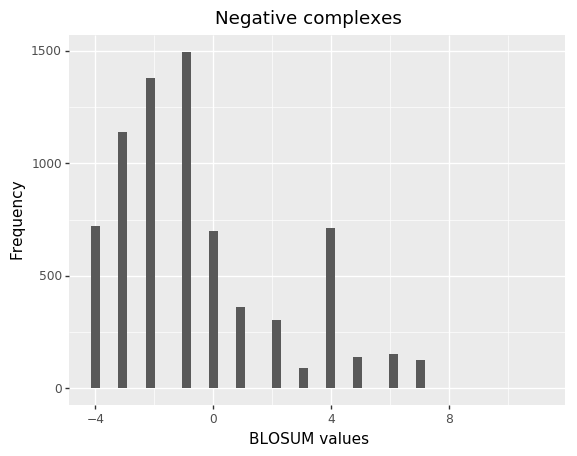

<ggplot: (8790060063019)>

In [628]:
df = pd.DataFrame(peptide_high.to_numpy().flatten())
(ggplot(df, aes(x = df))
    + geom_histogram(bins=50)
    + ggtitle("Histogram")
    + xlab("BLOSUM values")
    + ylab("Frequency")
    + ggtitle("Negative complexes")
)

In [ ]:
print()

In [575]:
6.060304027491623e-226*1000

6.060304027491623e-223

In [435]:
test = ["one", "two", "three", "four"]

In [463]:
choice = random.choice(neg.index)

In [467]:
neg.shape, neg.drop(choice).shape

((732, 10), (731, 10))

In [438]:
random.choice(test)

'three'

In [396]:
choice = random.choice(neg)


5

In [ ]:
df exclude positives
compariosn between MW U

sel random among negs

#SIMULATED ANNEALING

blosum pep data:

while mw (data[mask] (negs) < 0.05):

select random element
calc average all elements

choice function:
if e ^ (avg(elements) - rand.choice(element) ) / k  > random.random ({0 - 1}) 

update mask: mask = mask - selection



In [382]:
peptide_pos = pd.DataFrame(peptide_pos.to_numpy().flatten())
peptide_high = pd.DataFrame(peptide_high.to_numpy().flatten())
peptide_low = pd.DataFrame(peptide_low.to_numpy().flatten())
peptide_switch = pd.DataFrame(peptide_switch.to_numpy().flatten())

In [383]:
print("Pos vs switch:", scipy.stats.mannwhitneyu(peptide_pos, peptide_switch))
print("Pos vs high:", scipy.stats.mannwhitneyu(peptide_pos, peptide_high))
print("Pos vs low:", scipy.stats.mannwhitneyu(peptide_pos, peptide_low))

Pos vs switch: MannwhitneyuResult(statistic=2956362.5, pvalue=0.3376120219523998)
Pos vs high: MannwhitneyuResult(statistic=5096378.5, pvalue=4.4217061397069526e-226)
Pos vs low: MannwhitneyuResult(statistic=1815367.0, pvalue=3.8964065606371034e-125)
